In [5]:
#imports

import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
np.random.seed(1)

cloud_scatterer = at3d.util.load_from_csv('/Users/khargenr/AT3D/at3d/data/synthetic_cloud_fields/jpl_les/rico32x37x26.txt',
                                           density='lwc',origin=(0.0,0.0))

#load atmosphere
atmosphere = xr.open_dataset('/Users/khargenr/AT3D/at3d/data/ancillary/AFGL_summer_mid_lat.nc')
#subset the atmosphere, choose only the bottom four km.
reduced_atmosphere = atmosphere.sel({'z': atmosphere.coords['z'].data[atmosphere.coords['z'].data <= 4.0]})
#merge the atmosphere and cloud z coordinates
merged_z_coordinate = at3d.grid.combine_z_coordinates([reduced_atmosphere,cloud_scatterer])

# define the property grid - which is equivalent to the base RTE grid
rte_grid = at3d.grid.make_grid(cloud_scatterer.x.diff('x')[0],cloud_scatterer.x.data.size,
                          cloud_scatterer.y.diff('y')[0],cloud_scatterer.y.data.size,
                          cloud_scatterer.z.data)

#finish defining microphysics because we can.

cloud_scatterer_on_rte_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer)

#We choose a gamma size distribution and therefore need to define a 'veff' variable.
size_distribution_function = at3d.size_distribution.gamma

cloud_scatterer_on_rte_grid['veff'] = (cloud_scatterer_on_rte_grid.reff.dims,
                                       np.full_like(cloud_scatterer_on_rte_grid.reff.data, fill_value=0.1))

In [6]:
solar_zenith = [60, 45, 0, 45, 60]
cos_solar_zenith = np.cos(np.radians(solar_zenith))
solar_azimuth = [90, 90, 90, -90, -90]
wavelengths = [.470, .550, .660, .865] 
sensor_zenith = 26.1
sensor_azimuth = 65.0

sensor_dicts = []
for i in range(len(solar_azimuth)):
    sensor_dict = at3d.containers.SensorsDict()
    for wavelength in wavelengths:
        sensor_dict.add_sensor('MSPI', 
                at3d.sensor.orthographic_projection(wavelength, cloud_scatterer,0.02,0.02, sensor_azimuth, sensor_zenith,
                                         altitude='TOA', stokes='I'))
    sensor_dicts.append(sensor_dict)

mie_mono_tables = OrderedDict()
for wavelength in wavelengths:
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )

optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    size_distribution_function,
    reff=np.linspace(5.0,45,40),
    veff=np.linspace(0.03,0.37,18),
)
optical_properties = optical_property_generator(cloud_scatterer_on_rte_grid)

# one function to generate rayleigh scattering.
rayleigh_scattering = at3d.rayleigh.to_grid(wavelengths,atmosphere,rte_grid)

solver_dicts = []
for cos_zen, azi in zip(cos_solar_zenith, solar_azimuth):
    solvers_dict = at3d.containers.SolversDict()
    # note we could set solver dependent surfaces / sources / numerical_config here
    # just as we have got solver dependent optical properties.
    
    for wavelength in sensor_dicts[0].get_unique_solvers():
        medium = {
            'cloud': optical_properties[wavelength],
            'rayleigh':rayleigh_scattering[wavelength]
         }
        config = at3d.configuration.get_config()
        solvers_dict.add_solver(
            wavelength,
            at3d.solver.RTE(
                numerical_params=config,
                surface=at3d.surface.lambertian(0.0),
                source=at3d.source.solar(wavelength, cos_zen,azi),
                medium=medium,
                num_stokes=1#sensor_dict.get_minimum_stokes()[wavelength],
            )                   
        )
        solver_dicts.append(solvers_dict)

In [7]:
%%time
for i, sensor_dict in enumerate(sensor_dicts):
    # solve the 4 RTEs in parallel AND get the measurements.
    sensor_dicts.get_measurements(solver_dicts[i], n_jobs=4, verbose=True)

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.470 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.550 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.865 micron]
     1  -0.748  0.378E+00    30784    40.64  0.159   [Radiance 0.660 micron]
     1  -0.757  0.373E+00    30784    40.64  0.159   [Radiance 0.470 micron]
     1  -0.751  0.375E+00    30784    40.64  0.159   [Radiance 0.550 micron]
     1  -0.745  0.383E+00    30784    40.64  0.159   [Radiance 0.865 micron]
     2  -1.320  0.420E+00    30784    40.64  0.159   [Radiance 0.660 micron]
     2  -1.329  0.413E+00    30784    40.64  0.159   [Radiance 0.470 micron]
     2  -1.319  0.425E+00    30784    40.64  0.159   [Radiance 0.865 micron]
     2  -1.323  0.416E+00    30784    40.64  0.159   [Radiance 0.550 micron]
     3  -1.648  0.433E+00    30784    40.64  0.159   [Radiance 0.660 micron]
     3  -1.

In [11]:
print(sensor_dicts[0] == sensor_dicts[1])

True


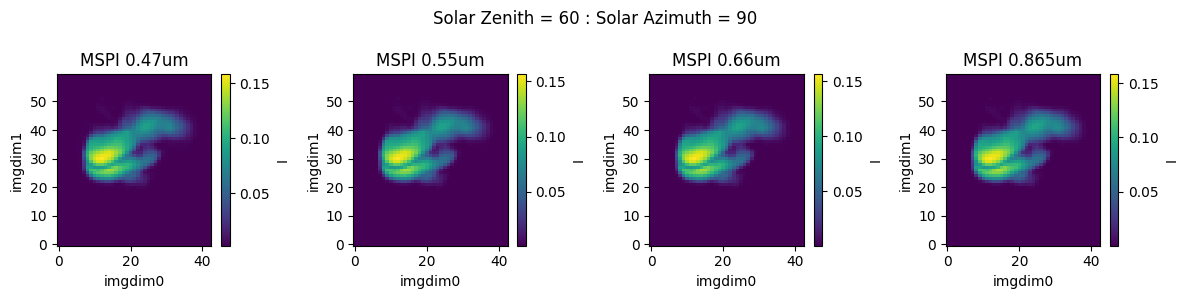

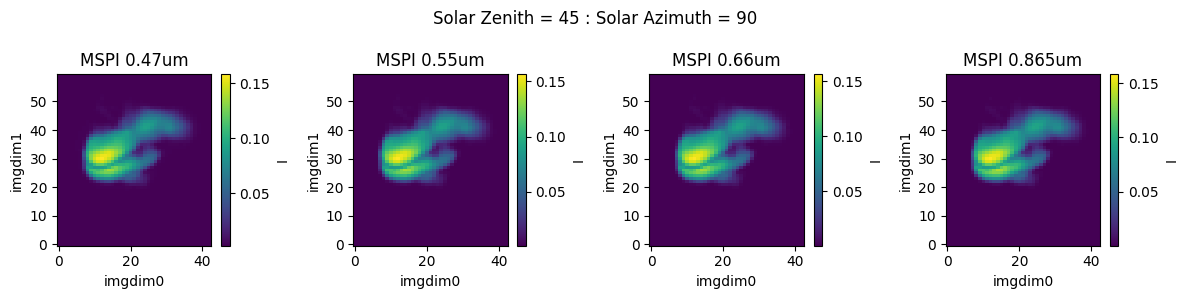

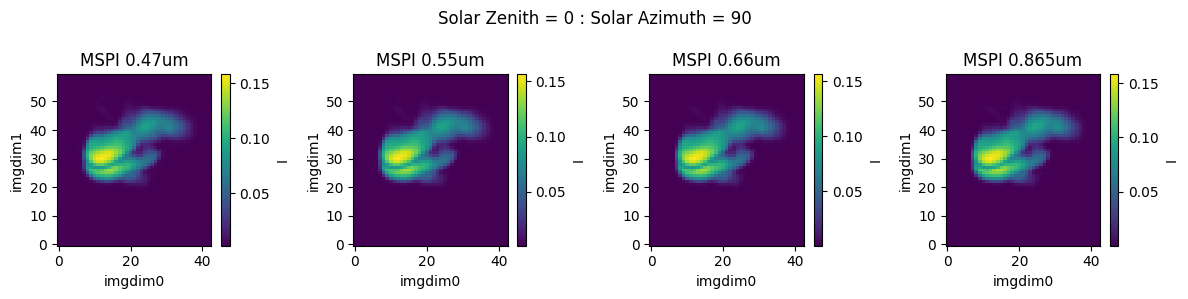

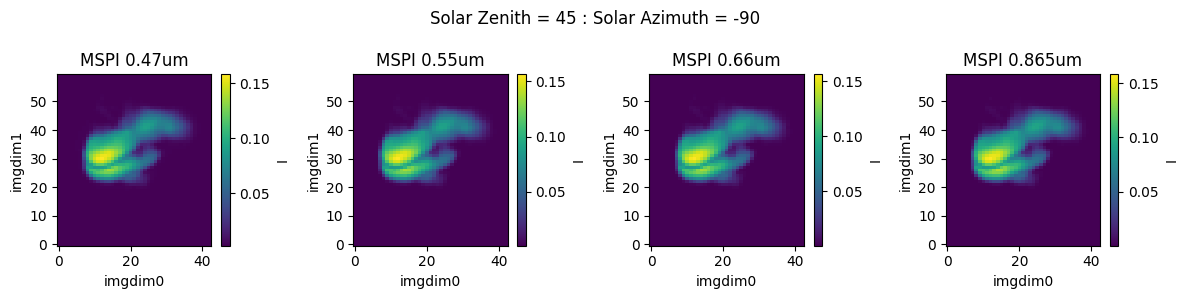

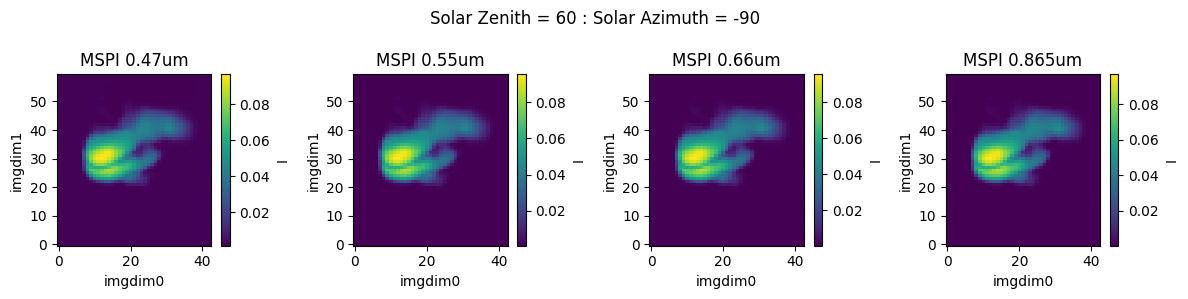

In [9]:
#plot
cmap = py.get_cmap('viridis')
cmap.set_under('white')
for i,sensor_dict in enumerate(sensor_dicts):
    fig, axs = py.subplots(1, len(wavelengths), figsize=(12, 3))  # Create a figure with subplots side by side
    py.suptitle("Solar Zenith = " + str(solar_zenith[i]) + " : Solar Azimuth = " + str(solar_azimuth[i]))
    for instrument in sensor_dict:
        sensor_images = sensor_dicts[i].get_images(instrument)
        for j,sensor in enumerate(sensor_images):
            sensor.I.T.plot(ax=axs[j])#, vmin=.000001, vmax=.005, cmap=cmap)
            axs[j].set_title(instrument + " " + str(wavelengths[j]) + "um")
            #axs[j].colorbar.set_label("W/m^2/steradian/micron")
    py.tight_layout()  # Adjust layout for better spacing
    py.show()